<a href="https://colab.research.google.com/github/Rahul711sharma/Credit-Card-Default-/blob/main/Credit_Card_Default.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Objective

* To predict the chances of Credit Card Default made by the Client.

## <b> Data Description </b>

### <b>Attribute Information: </b>

### This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:
* ### X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
* ### X2: Gender (1 = male; 2 = female).
* ### X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
* ### X4: Marital status (1 = married; 2 = single; 3 = others).
* ### X5: Age (year).
* ### X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
* ### X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
* ### X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.

##Importing Libraries

In [38]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

openjdk-8-jdk-headless is already the newest version (8u292-b10-0ubuntu1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [39]:
import pyspark
import pyspark.sql as sql

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
import plotly.express as pe
%matplotlib inline

In [41]:
sc = pyspark.SparkContext()

In [42]:
sqlContext = pyspark.SQLContext(sc)

## Importing Data

In [121]:
df = pd.read_excel("https://raw.githubusercontent.com/Rahul711sharma/Credit-Card-Default-/main/default%20of%20credit%20card%20clients.xls")
df.head(3)


,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1


In [122]:
df = pd.read_excel("https://raw.githubusercontent.com/Rahul711sharma/Credit-Card-Default-/main/default%20of%20credit%20card%20clients.xls",header=1)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [123]:
sql_df = sqlContext.createDataFrame(df)

In [124]:
spark = pyspark.sql.SparkSession.builder.getOrCreate()

In [125]:
sql_df.select('*').limit(10).show()

+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default payment next month|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
|  1|    20000|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|     3913|     3102|      689|        0|        0|        0|       0|     689|       0|       0|       0|       0|                         1|
|  2|   120000|  2|        2|       2| 26|   -1|    2|    0|    0|    0|    2|     2682|     1725|     2682|     3272|  

## Describe Data

In [126]:
sql_df.summary().show()

+-------+-----------------+------------------+------------------+------------------+------------------+-----------------+-----------------+--------------------+------------------+--------------------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+-----------------+--------------------------+
|summary|               ID|         LIMIT_BAL|               SEX|         EDUCATION|          MARRIAGE|              AGE|            PAY_0|               PAY_2|             PAY_3|               PAY_4|             PAY_5|            PAY_6|        BILL_AMT1|        BILL_AMT2|        BILL_AMT3|        BILL_AMT4|         BILL_AMT5|        BILL_AMT6|          PAY_AMT1|          PAY_AMT2|         PAY_AMT3|          PAY_AMT4|          PAY_AMT5|         PAY_AMT6|default payment next month|
+-------+-----------------+-

In [127]:
type(sql_df)

pyspark.sql.dataframe.DataFrame

In [128]:
sql_df.toPandas().shape

(30000, 25)

##Null Values In data

In [129]:
sql_df.filter(sql_df.SEX.isNull()).count()

0

In [130]:
sql_df.toPandas().isna().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

##Exploratory Data 

### Playground with Categorical Data Exploration

In [131]:
sql_df.createOrReplaceTempView('data')

In [132]:
sql_df.columns

['ID',
 'LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

In [133]:
spark.sql(f"select SEX,count(*) as Count from data group by SEX").show()

+---+-----+
|SEX|Count|
+---+-----+
|  1|11888|
|  2|18112|
+---+-----+



In [134]:
# Function to find distinct Values

def distinct_values(data):
  for i in data.columns:
    #distinct values with less than 30 unique values
    if len(set(list(data[i])))<30:
      print(f"{i} Distinct Values :  \n {data[i].value_counts()} \n")

In [135]:
distinct_values(sql_df.toPandas())

SEX Distinct Values :  
 2    18112
1    11888
Name: SEX, dtype: int64 

EDUCATION Distinct Values :  
 2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64 

MARRIAGE Distinct Values :  
 2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64 

PAY_0 Distinct Values :  
  0    14737
-1     5686
 1     3688
-2     2759
 2     2667
 3      322
 4       76
 5       26
 8       19
 6       11
 7        9
Name: PAY_0, dtype: int64 

PAY_2 Distinct Values :  
  0    15730
-1     6050
 2     3927
-2     3782
 3      326
 4       99
 1       28
 5       25
 7       20
 6       12
 8        1
Name: PAY_2, dtype: int64 

PAY_3 Distinct Values :  
  0    15764
-1     5938
-2     4085
 2     3819
 3      240
 4       76
 7       27
 6       23
 5       21
 1        4
 8        3
Name: PAY_3, dtype: int64 

PAY_4 Distinct Values :  
  0    16455
-1     5687
-2     4348
 2     3159
 3      180
 4       69
 7       58
 5       3

In [136]:
# Core Categorical Data
Cat_data = ['SEX','EDUCATION','MARRIAGE','default payment next month']

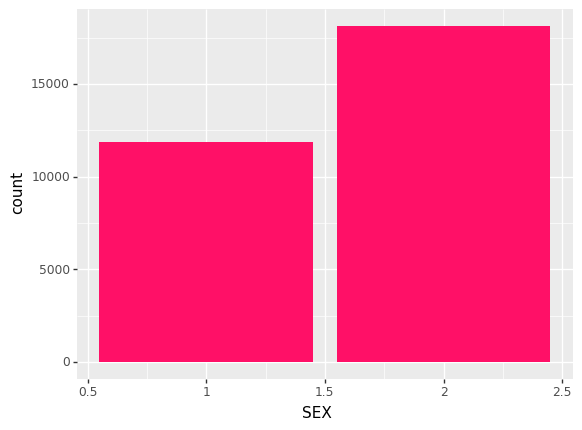

<ggplot: (8747149087729)>


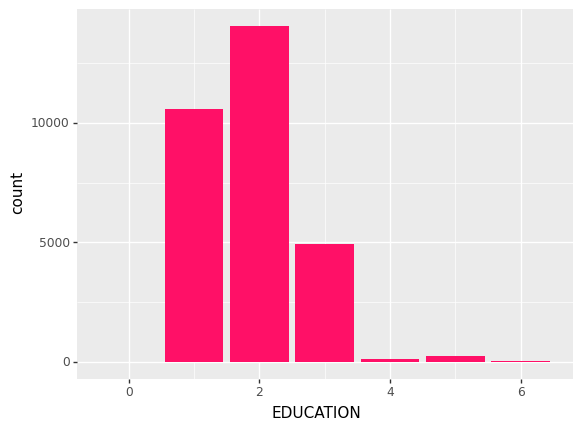

<ggplot: (8747149014169)>


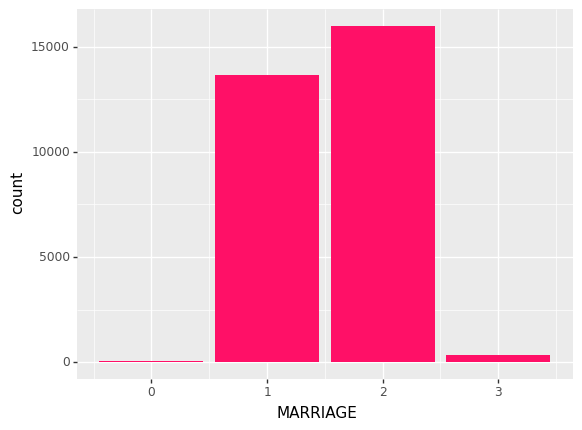

<ggplot: (8747166552737)>


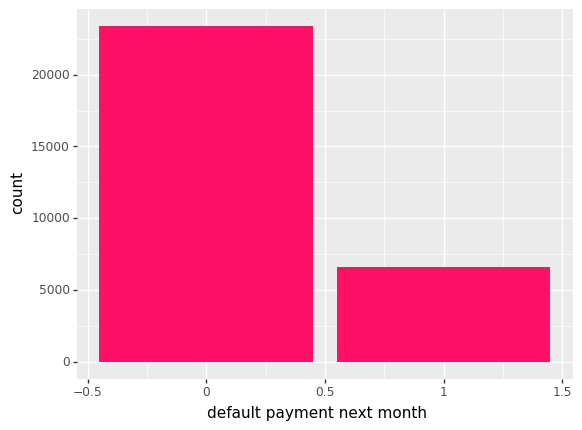

<ggplot: (8747149062569)>


In [137]:
# Bar graphs
for i in Cat_data:
  print(ggplot(sql_df.toPandas())+aes(i,color=i)+geom_bar(fill = "#FF1067"))


Treatment of classes with close to none observations. We either remove them or add them to a majority class.

In [138]:
df2 = sql_df.toPandas()

In [139]:
df2['MARRIAGE']=df2['MARRIAGE'].replace({3:1,2:1,1:0})

In [140]:
df2['EDUCATION'] = df2['EDUCATION'].replace({1:0,2:1,3:2,4:2,5:2,6:2})
df2['EDUCATION'].value_counts()

1    14030
0    10599
2     5371
Name: EDUCATION, dtype: int64

In [141]:
df2['SEX']= df2['SEX'].replace({2:1,1:0})
df2['SEX'].value_counts()

1    18112
0    11888
Name: SEX, dtype: int64

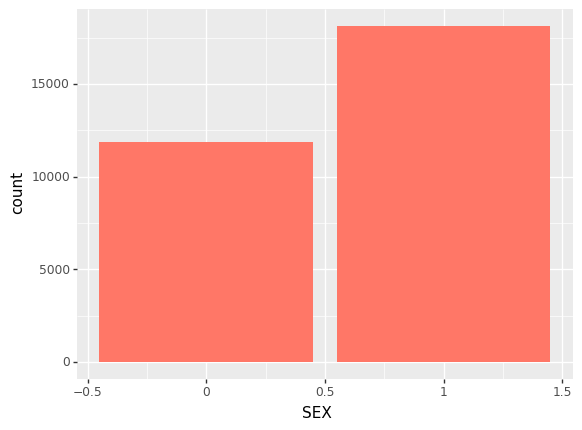

<ggplot: (8747154765149)>


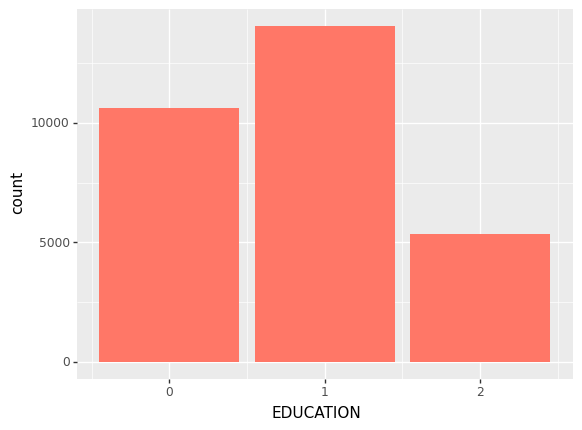

<ggplot: (8747167205973)>


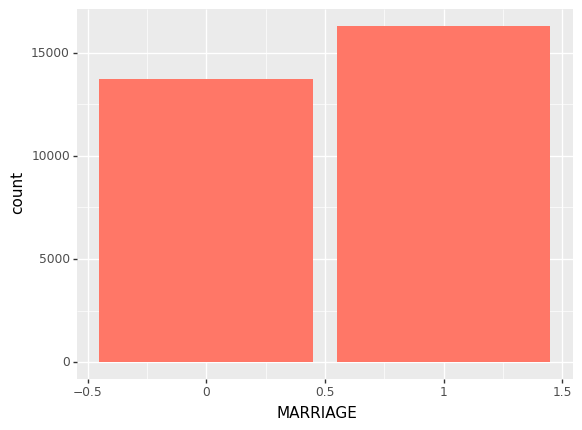

<ggplot: (8747167174281)>


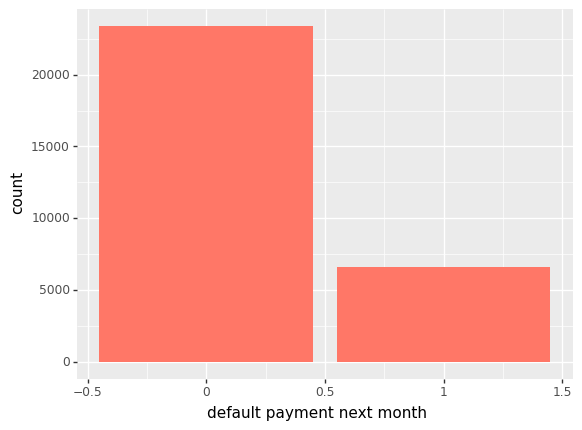

<ggplot: (8747164548553)>


In [142]:
# Bar graphs
for i in Cat_data:
  print(ggplot(df2)+aes(i,color=i)+geom_bar(fill = "#FF7767"))


* We can see that our dependent variable has a majority class. We need to pick model and algorithms complying to that in future.

In [143]:
Education_by_gender = pd.pivot_table(df2,index='EDUCATION',columns='SEX',aggfunc={'SEX':'count'})
Education_by_gender

SEX      
SEX           0     1
EDUCATION            
0          4362  6237
1          5374  8656
2          2152  3219

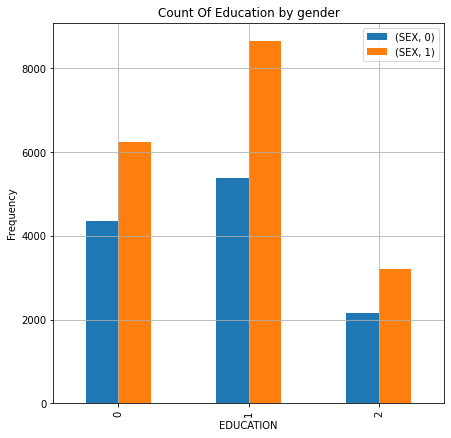

In [195]:
Education_by_gender.plot(kind='bar',figsize=(7,7),grid=1)
plt.title("Count Of Education by gender")
plt.ylabel('Frequency')
plt.legend()

**People who defaulted groups in diffrent categories**


In [173]:
# Default by education
Default_by_education = pd.DataFrame(pd.pivot_table(df2,index='EDUCATION',columns='default payment next month',aggfunc={'default payment next month':'count'}))
Default_by_education

default payment next month      
default payment next month                          0     1
EDUCATION                                                  
0                                                8563  2036
1                                               10700  3330
2                                                4101  1270

Text(0.5, 1.0, 'Count of People who defaulted by education')

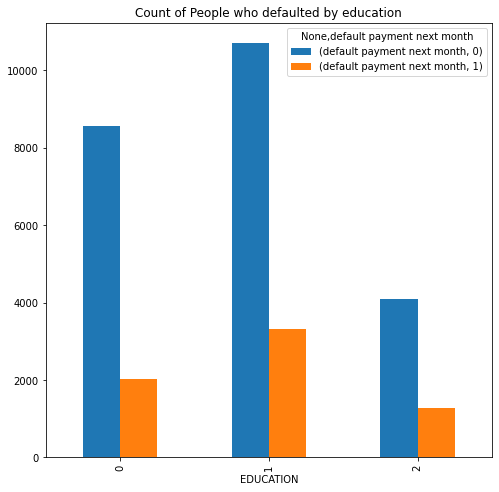

In [187]:
Default_by_education.plot(kind='bar',y= ['default payment next month'],stacked=0,figsize=(8,8))

plt.title('Count of People who defaulted by education')

In [175]:
# Default by gender
Default_by_gender = pd.DataFrame(pd.pivot_table(df2,index='SEX',columns='default payment next month',aggfunc={'default payment next month':'count'}))
Default_by_gender

default payment next month      
default payment next month                          0     1
SEX                                                        
0                                                9015  2873
1                                               14349  3763

Text(0.5, 1.0, 'Count of People who defaulted by gender')

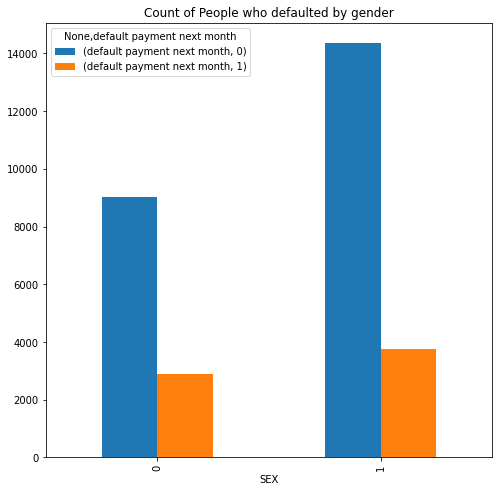

In [188]:
Default_by_gender.plot(kind='bar',y= ['default payment next month'],stacked=0,figsize=(8,8))

plt.title('Count of People who defaulted by gender')

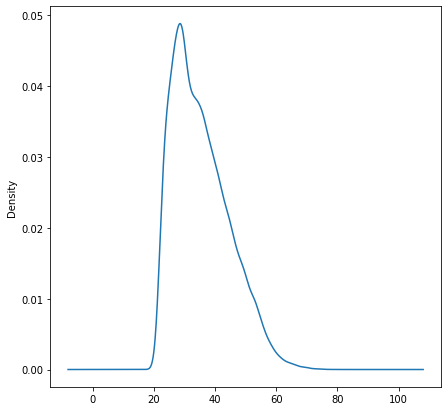

In [209]:
(df2['AGE']).plot(kind='density',figsize=(7,7))

##Train test split 

In [ ]:
df2 = df2.iloc[:,1:]
df2.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,1,1,0,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,120000,1,1,1,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,1,1,1,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,1,1,0,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,0,1,0,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [ ]:
x = df2.drop('default payment next month',axis='columns')
y = df2['default payment next month']
print(f"{x.shape}\n {y.shape}")

(30000, 23)
 (30000,)


In [ ]:
from sklearn.model_selection import train_test_split
X_train,x_test,y_train,y_test = train_test_split(x,y, random_state=42)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

NameError: ignored

###Logistic Regression Model

In [ ]:
from sklearn.metrics import  roc_auc_score,accuracy_score
from sklearn.linear_model import LogisticRegression

In [ ]:
logit = LogisticRegression(max_iter=100000)

In [ ]:
logit.fit(x_train,y_train)

In [ ]:
accuracy_score(y_train,logit.predict(x_train))

In [ ]:
from sklearn.svm import SVC
# we can add class_weight='balanced' to add penalize
svc_model = SVC(class_weight='balanced', probability=True)

svc_model.fit(x_train, y_train)


In [ ]:
#accuracy score on train

svc_predict_train = svc_model.predict(x_train)
print('Accuracy score:',accuracy_score(y_train, svc_predict_train))

In [ ]:
svc_predict = svc_model.predict(x_test)
print('ROCAUC score:',roc_auc_score(y_test, svc_predict))
print('Accuracy score:',accuracy_score(y_test, svc_predict))

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dt= DecisionTreeClassifier(class_weight="balanced")
dt.fit(x_train,y_train)

In [ ]:
accuracy_score(y_test,dt.predict(x_test))

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
gboost = GradientBoostingClassifier()
gboost.fit(x_train,y_train)

In [ ]:
accuracy_score(y_train,gboost.predict(x_train))

In [ ]:
accuracy_score(y_test,gboost.predict(x_test))

In [ ]:
from sklearn.model_selection import GridSearchCV

#number of trees
n_estimators = [100,120]

#Maximum depth of tree
max_depth = [6,8]

# Minimum number of samples required to split a node
min_samples_split = [50,100]

# Minimum number of samples required at each leaf node
min_samples_leaf = [40,50]

param_dict = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}


In [ ]:
gboost2= GradientBoostingClassifier()
gb_grid =GridSearchCV(estimator=gboost2, param_grid = param_dict,cv = 5, verbose=2)
gb_grid.fit(x_train,y_train)

In [ ]:
accuracy_score(y_train,gb_grid.predict(x_train))

In [ ]:
accuracy_score(y_test,gb_grid.predict(x_test))

In [ ]:
import xgboost

In [ ]:
xgb = xgboost.XGBClassifier(max_depth=10,)
xgb.fit(x_train,y_train)

In [ ]:
accuracy_score(y_train,xgb.predict(x_train))

In [ ]:
accuracy_score(y_test,xgb.predict(x_test))

In [ ]:
#number of trees
n_estimators = [120]

#Maximum depth of tree
max_depth = [20]

# Minimum number of samples required to split a node
min_samples_split = [100]

# Minimum number of samples required at each leaf node
min_samples_leaf = [40,50]

param_dict2 = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}


In [ ]:
xgb2 = xgboost.XGBClassifier()
xgb_cv= GridSearchCV(estimator=xgb2, param_grid = param_dict2,cv = 5, verbose=2)
xgb_cv.fit(x_train,y_train)

In [ ]:
accuracy_score(y_train,xgb_cv.predict(x_train))

In [ ]:
accuracy_score(y_test,xgb_cv.predict(x_test))